In [1]:
pip install scikit-image matplotlib scipy


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: /usr/local/Cellar/jupyterlab/4.3.4_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
#importing required libraries
from skimage.io import imread, imshow
from skimage.transform import resize, rotate
from skimage.feature import hog
from skimage.color import rgb2gray
from scipy import spatial
import matplotlib.pyplot as plt
import numpy as np
import glob
import time

----------------------------------------------PREPROCESSING-----------------------------------------------------

In [3]:
def pre_treatment(img) :
    resized_img = resize(img, (128*4, 64*4))
    if (img.shape[-1] == 4) :
        return rgb2gray(resized_img[:,:,:3])
    elif (img.shape[-1] == 3) :
        return rgb2gray(resized_img)
    else :
        return resized_img

In [4]:
def hog_wrapper(treated_img) :
    fd, hog_image = hog(treated_img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True)
    return fd

In [5]:
def get_embedding(img) :
    treated_img = pre_treatment(img)
    return hog_wrapper(treated_img)

In [6]:
def embed_image_list(path_list, image_list) :
    for path in path_list :
        image_list.append((get_embedding(imread(path)),path.split("/")[-1]))
        

In [18]:
#Get all paths
query_images_paths = glob.glob('./*.jpg')
database_images_paths = glob.glob('./database/*.jpg')

In [19]:
#Embedding of all the files
query_im_list = []
db_im_list = []

embed_image_list(sorted(query_images_paths), query_im_list)
embed_image_list(database_images_paths, db_im_list)

----------------------------------------------SCORES-------------------------------------------------

In [20]:
def get_scores(metric, query_list, db_list) :
    score_list = []

    for q in query_list :
        l = []
        for im in db_list :
           score = 0
           if (metric == "cosine") :
               score = spatial.distance.cosine(q[0],im[0])
           elif (metric == "canberra") :
                 score = spatial.distance.canberra(q[0],im[0])
           l.append((score,im[1]))
        l.sort(key = lambda x : x[0])
        score_list.append({"name" : q[1], "score_list" : l})
    return score_list 

In [21]:
cosine_scores = get_scores("cosine", query_im_list, db_im_list)
canberra_scores = get_scores("canberra", query_im_list, db_im_list)

In [22]:
#Run this if you want the the complete ranking for each query picture
cosine_scores

[{'name': 'airplane_query.jpg',
  'score_list': [(np.float64(0.32769348393397824), 'airplane_1.jpg'),
   (np.float64(0.3438088901519737), 'airplane_2.jpg'),
   (np.float64(0.369643557756163), 'cat_2.jpg'),
   (np.float64(0.3744123391571401), 'airplane_3.jpg'),
   (np.float64(0.37621138471367577), 'cat_4.jpg'),
   (np.float64(0.37908240076312827), 'airplane_4.jpg'),
   (np.float64(0.38230456412046954), 'ball_4.jpg'),
   (np.float64(0.38263389632074984), 'car_4.jpg'),
   (np.float64(0.38620887769289236), 'lotus_4.jpg'),
   (np.float64(0.39072995100867225), 'lotus_1.jpg'),
   (np.float64(0.39387194248545854), 'car_3.jpg'),
   (np.float64(0.3985729107610828), 'cat_3.jpg'),
   (np.float64(0.4086407617966086), 'face_1.jpg'),
   (np.float64(0.40917416496585046), 'car_2.jpg'),
   (np.float64(0.40985966660494744), 'airplane_5.jpg'),
   (np.float64(0.4107092022690141), 'face_5.jpg'),
   (np.float64(0.41189445468824426), 'lotus_5.jpg'),
   (np.float64(0.41247763482797173), 'pickles_2.jpg'),
   (n

In [23]:
#average score for each categories
average_score = []

for score in cosine_scores :
    name = score['name'].split('_')[0]
    elems = []

    for elem in score['score_list'] : 
        if name in elem [1] :
            elems.append(elem[0])
    average_score.append((name, sum(elems) / len(elems)))

print(average_score)

[('airplane', np.float64(0.3669713561222335)), ('ball', np.float64(0.4503807553449155)), ('car', np.float64(0.35450058292727854)), ('cat', np.float64(0.33517153470978023)), ('dolphin', np.float64(0.4254284568285106)), ('face', np.float64(0.3142988769931672)), ('lotus', np.float64(0.5477562599060771)), ('pickles', np.float64(0.3853879378780918))]


In [24]:
#Get the number of images that are the top 10 and top 5 of their respective classes
top_10 = []
top_5 = []
for score in cosine_scores :

    category = score['name'].split("_")[0]
    count_top_10 = 0
    count_top_5 = 0
    raking_based_on_name = [x[1] for x in score['score_list']]

    for elem in score['score_list'][:10] :
        if category in elem[1] :

          if raking_based_on_name.index(elem[1]) < 5 :
            count_top_5 = count_top_5 + 1

          count_top_10 = count_top_10 + 1

    top_5.append((category,count_top_5))
    top_10.append((category,count_top_10))

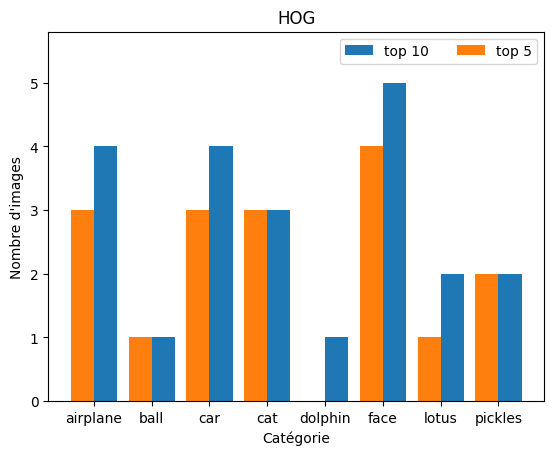

In [35]:
name, top_10_rate = zip(*top_10)
_, top_5_rate = zip(*top_5)
x = np.arange(len(list(name)))

plt.bar(x + 0.2,list(top_10_rate), 0.4, label = 'top 10')
plt.bar(x - 0.2, list(top_5_rate), 0.4, label = 'top 5')
plt.xticks(x, list(name))
plt.xlabel("Catégorie")
plt.ylabel("Nombre d'images")
plt.ylim(0,5.8)
plt.legend(ncol=2)
plt.title('HOG')
plt.show()

----------------------------------------------TIMES-------------------------------------------------

In [26]:
def get_time (img_arr) :
    start_time = time.time() #Getting the elapsed time
    for img in img_arr :
        hog_wrapper(img)
    end_time = time.time()
    return end_time - start_time

In [27]:
def do_all_pretreatment(path_arr) :
    img_arr = []
    for path in path_arr :
        img = pre_treatment(imread(path))
        img_arr.append(img)
    return img_arr

In [ ]:
# Here we are going to calculate the embedding time  for 1, 5, 10, 25 and the total numbers of pictures
time_table = []

#1 pic
one_pic_time = get_time(do_all_pretreatment(query_images_paths[:1]))
time_table.append(one_pic_time)

#5 pics
five_pics_time = get_time(do_all_pretreatment(query_images_paths[:5]))
time_table.append(five_pics_time)

#10 pics
ten_pics_time = get_time(do_all_pretreatment(database_images_paths[:10]))
time_table.append(ten_pics_time)

#25 pics
twenty_five_pics_time = get_time(do_all_pretreatment(database_images_paths[:25]))
time_table.append(twenty_five_pics_time)

#total (48 pics)
combined_path_array = query_images_paths + database_images_paths
all_pics_time = get_time(do_all_pretreatment(combined_path_array))
time_table.append(all_pics_time)

time_table = np.round(time_table, 2)

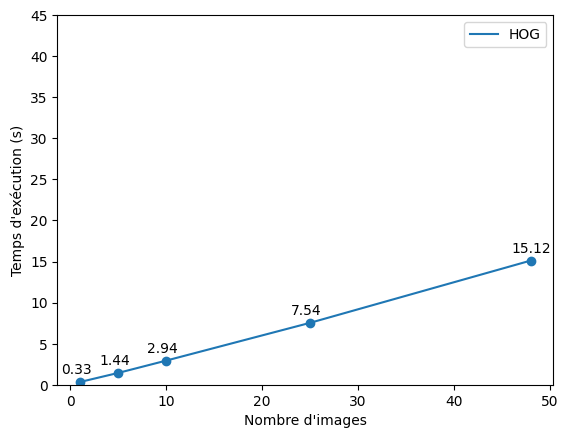

In [34]:
#Plotting the results
plt.xlabel("Nombre d'images")
plt.ylabel("Temps d'exécution (s)")
nb_images = [1,5,10,25,48]
plt.scatter(nb_images, time_table)
plt.plot(nb_images, time_table, label = 'HOG')
plt.ylim(0, 45)
for i, txt in enumerate(time_table):
    plt.annotate(str(txt), (nb_images[i] - 2, time_table[i] + 1))
plt.legend()
plt.show()

In [29]:
print(time_table)

[ 0.33  1.44  2.94  7.54 15.12]


--------------------------------------IN PLANE ROTATION-------------------------------------------

In [18]:
#Get the score list for the dolphins images because they have rotations 
dolphin_ranking = cosine_scores[4]['score_list']
raking_based_on_name = [x[1] for x in dolphin_ranking]
dolphin_data = []

#get the ranking of every dolphin picture in the database
for n in range(1,6) :
    name = 'dolphin_' + str(n) + '.jpg'
    rank = raking_based_on_name.index(name)
    dolphin_data.append((name,rank + 1))
    print(name + '|' + str(rank + 1))

dolphin_1.jpg|10
dolphin_2.jpg|26
dolphin_3.jpg|34
dolphin_4.jpg|27
dolphin_5.jpg|13


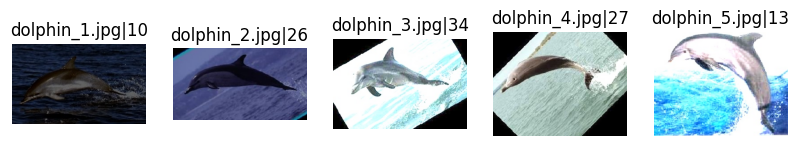

In [19]:
fig = plt.figure(figsize=(10, 7))
dolphin_paths = sorted(list(filter(lambda x: ('dolphin' in x),database_images_paths )))
im_list = []

for dp in dolphin_paths :
    im_list.append(imread(dp))

for i in range(1,6) :
    plt.subplot(1,5,i)
    plt.imshow(im_list[i-1])
    plt.axis('off')
    plt.title(dolphin_data[i-1][0] + '|' + str(dolphin_data[i-1][1]))
    
plt.show()   

In [1]:
#Lets get face_5 and rotate it to see the effect
best_face = cosine_scores[5]['score_list'][0]
print('its cosine score is ' + str(best_face[0]))

NameError: name 'cosine_scores' is not defined

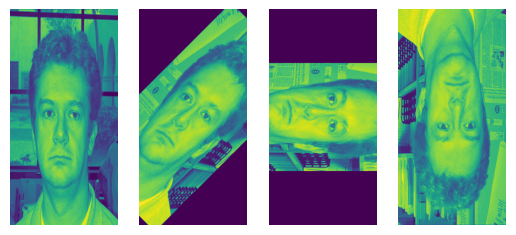

In [21]:
#Lets see how much a rotation can break face detection, wich HOG is pretty good at
query_image = pre_treatment(imread('./face_query.jpg'))
db_image = pre_treatment(imread('./database/' + best_face[1]))

rotated_45 = rotate(db_image, -45)
rotated_90 = rotate(db_image, -90)
rotated_180 = rotate(db_image, -180)

img_list = [(query_image, 'query'),(rotated_45, '45'),(rotated_90, '90'),(rotated_180, '180')]

for i in range(1,5) :
    plt.subplot(1,4,i)
    plt.imshow(img_list[i-1][0])
    plt.axis("off")
plt.show()

In [22]:
#embedding + getting the scores
embedded_list = []
for img in img_list :
    embedded_list.append((hog_wrapper(img[0]), img[1]))

scores = get_scores("cosine", [embedded_list[0]], embedded_list[1:4])

In [23]:
#Printing the scores
for s in scores[0]['score_list'] :
    print(s[1] + ' : ' + str(s[0]))

180 : 0.3520036984896051
45 : 0.5797293836506738
90 : 0.6085759945177167


-----------------------------------------BOUNDING BOXES---------------------------------------------

In [25]:
#Get the score list for the cars
ball_ranking = cosine_scores[1]['score_list']
raking_based_on_name = [x[1] for x in ball_ranking]
car_data = []

#get the score of every car picture in the database
for n in range(1,6) :
    name = 'ball_' + str(n) + '.jpg'
    rank = raking_based_on_name.index(name)
    print(name + ':' +  str(ball_ranking[rank][0]))

ball_1.jpg:0.379758028419903
ball_2.jpg:0.6202707768187932
ball_3.jpg:0.38730410366691037
ball_4.jpg:0.3362923233520104
ball_5.jpg:0.5282785444669605


In [26]:
#Get the scores for the bounding boxes car images
bb_paths = sorted(glob.glob("./bb_database/*.jpeg"))
im_arr = do_all_pretreatment(bb_paths)
embedded_list = []

for i in range(0,6) :
    embedded_list.append((hog_wrapper(im_arr[i]), bb_paths[i]))
    
scores = get_scores("cosine", [embedded_list[-1]], embedded_list[:5])

#Printing the scores
for s in scores[0]['score_list'] :
    print(s[1].split('/')[-1] + ' : ' + str(s[0]))

bbBall_4.jpeg : 0.33118927799366005
bbBall_3.jpeg : 0.3819276090727969
bbBall_1.jpeg : 0.403473746076903
bbBall_5.jpeg : 0.4288710664502521
bbBall_2.jpeg : 0.5236996890538146


-----------------------------------TEXTURE---------------------------------------------

In [37]:
#Since HOG is really good regarding texture, it should recognize the right patern no matter the object and it should do better 
# with those different object than with similar objects with different patterns


#embedding the images
texture_paths = glob.glob('./texture_database/*.png')
texture_images = []
embed_image_list(sorted(texture_paths),texture_images)

query = texture_images[-1]
db = texture_images[:-1]

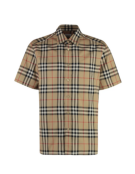

In [38]:
#We will compare this plaid shirt
fig = plt.figure(figsize=(3, 2))
plt.axis("off")
plt.imshow(imread(sorted(texture_paths)[-1]))

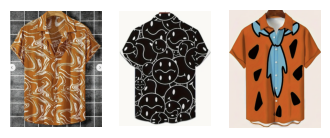

In [39]:
#to these 3 other shirts who have differents textures
fig = plt.figure(figsize=(4, 2))
shirts = sorted(texture_paths[-4:-1])
for i in range (1,4) :
    plt.subplot(1,3,i)
    plt.imshow(imread(shirts[i-1]))
    plt.axis("off")
plt.show()

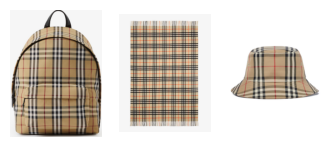

In [40]:
#and to these 3 object (blanket, bag and hat) that have the same texture
fig = plt.figure(figsize=(4, 2))
objects = sorted(texture_paths)[0:4]
for i in range (1,4) :
    plt.subplot(1,3,i)
    plt.imshow(imread(objects[i-1]))
    plt.axis("off")
plt.show()

In [41]:
#Now lets get the scores
get_scores('cosine',[query], db)

[{'name': 'shirt_query.png',
  'score_list': [(np.float64(0.501244525865392), 'bag.png'),
   (np.float64(0.546841995628076), 'blanket.png'),
   (np.float64(0.557641393639493), 'hat.png'),
   (np.float64(0.5882280948339207), 'shirt_flinstone.png'),
   (np.float64(0.5884443954919757), 'shirt_abstact.png'),
   (np.float64(0.6565858750414044), 'shirt_face.png')]}]